# Tratamiento de Outilers

Los Outliers se pueden encontrar de varias diferentes maneras pero en este curso solo cubriremos las tres principales: 
## Sentido Común: 
Si estamos trabajando con fechas de nacimiento de nuestros clientes en una App y vemos un señor que tiene como fecha de nacimiento en 1801. Si queremos calcular la edad media de nuestros clientes, es importante eliminar o corregir ese registro.

## Métodos Estadísticos 
Los métodos estadísticos suelen ser suficientemente robustos en la mayoría de los casos. Lo que se busca es que la mayor cantidad de datos estén dentro de la norma.

## Con Machine Learning 
Se han desarrollado varias técnicas para encontrar Outliers con métodos de aprendizaje automático no supervisado.


Además del método, también es importante resaltar la cantidad de variables que se considerarán en el análisis, esto puede ser **Multivariable o univariable**. En este Notebook solo trataremos el enfoque univariable


En este tutorial veremos algunos ejemplos de cómo detectar Outliers. Empezamos creando los datos e importando librerías




In [1]:
# Importaciones
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


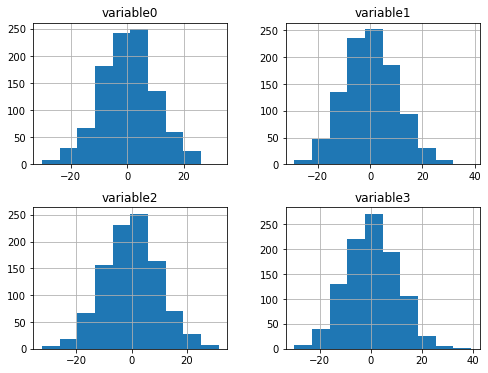

In [2]:
# Creamos un DataSet sintético para empezar 
# Random seed hace que lo aleatorio sea repetible 
np.random.seed(42)
n_feats = 4 # número variables
df_sin = pd.DataFrame(
    np.random.normal(
        scale=10.0, size=(1000, n_feats)),
        columns=[f'variable{i}' for i in range(n_feats)]
)
# todos tienen una distribución normal
df_sin.hist(figsize=(8,6));


In [3]:
# Vemos que de todas formas hay outliers
df_sin.describe()

,variable0,variable1,variable2,variable3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.306239,0.248285,-0.082552,0.300861
std,9.639191,10.118843,10.060754,10.069640
min,-30.195122,-28.962554,-32.412673,-29.911360
25%,-6.129422,-6.770368,-6.752986,-6.708710
50%,0.561874,0.202097,-0.075088,0.211577
75%,6.648813,6.938808,6.422820,6.958780
max,32.430930,38.527315,31.520567,39.262377


In [4]:
# Definimos funciones para encontrar Outliers estadísticos 
# La primera basada en desviación estandar y la segunda en quartiles
def out_std(s, nstd=3.0, return_thresholds=False):
    """
    Devuelve una máscara buleana de la posición de los 
    outliers en una serie usando el número de desviaciones 
    estándar. 
    :param s: Una serie 
    :param nstd: Número de desviaciones estándar
    :param return_thresholds: buleano, si es True devuelve los límites 
      (upper bound and lower bound)

    :return: Una máscara para la serie 
    """
    data_mean, data_std = s.mean(), s.std()
    cut_off = data_std * nstd
    lower, upper = data_mean - cut_off, data_mean + cut_off
    if return_thresholds:
        return lower, upper
    else:
        return [True if x < lower or x > upper else False for x in s]

def out_iqr(s, k=1.5, return_thresholds=False):
    """
    Devuelve una máscara buleana de la posición de los 
    outliers en una serie usando el rango intercuartil y un
    corte en k
    :param s: Una serie 
    :param k: corte, cutoff
    :param return_thresholds: buleano, si es True devuelve los límites 
      (upper bound and lower bound)

    :return: Una máscara
    """
    # calculate interquartile range
    q25, q75 = np.percentile(s, 25), np.percentile(s, 75)
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    if return_thresholds:
        return lower, upper
    else: # identify outliers
        return [True if x < lower or x > upper else False for x in s]

# Outliers por su Desviación estándar 
![Desviación estándar](https://qph.fs.quoracdn.net/main-qimg-a86744ea6f27735b381e097bed60e048.webp)
# Outliers por análisis de cuartiles 
![Cuartiles](http://www.statisticshowto.com/wp-content/uploads/2012/03/iqr.jpg)

In [ ]:
# Encontramos los Outliers en la primera columna
mascara = out_std(df_sin["variable0"], nstd=3) # encontramos los índices 
print(mascara[:10])

[False, False, False, False, False, False, False, False, False, False]


In [ ]:
# con la máscara podemos encontrar los outliers de la serie
df_sin['variable0'][mascara]

506   -30.195122
788   -29.069882
929    32.430930
Name: variable0, dtype: float64

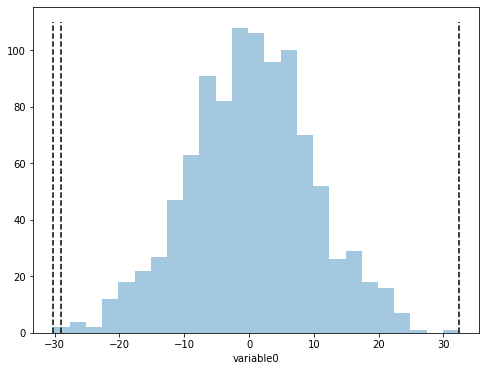

In [ ]:
# Los ploteamos 

plt.figure(figsize=(8,6))
sns.distplot(df_sin['variable0'], kde=False);
plt.vlines(df_sin['variable0'][mascara], ymin=0,
           ymax=110, linestyles='dashed');

In [ ]:
# Para comparar los diferentes parámetros marcamos diferentes valores de nstd
# For comparison, make one array each using standard deviations of 2.0, 3.0 and 4.0.
std2 = df_sin.apply(out_std, nstd=2.0) # aplicamos la función a todo el Dataframe
std3 = df_sin.apply(out_std, nstd=3.0)
std4 = df_sin.apply(out_std, nstd=4.0)



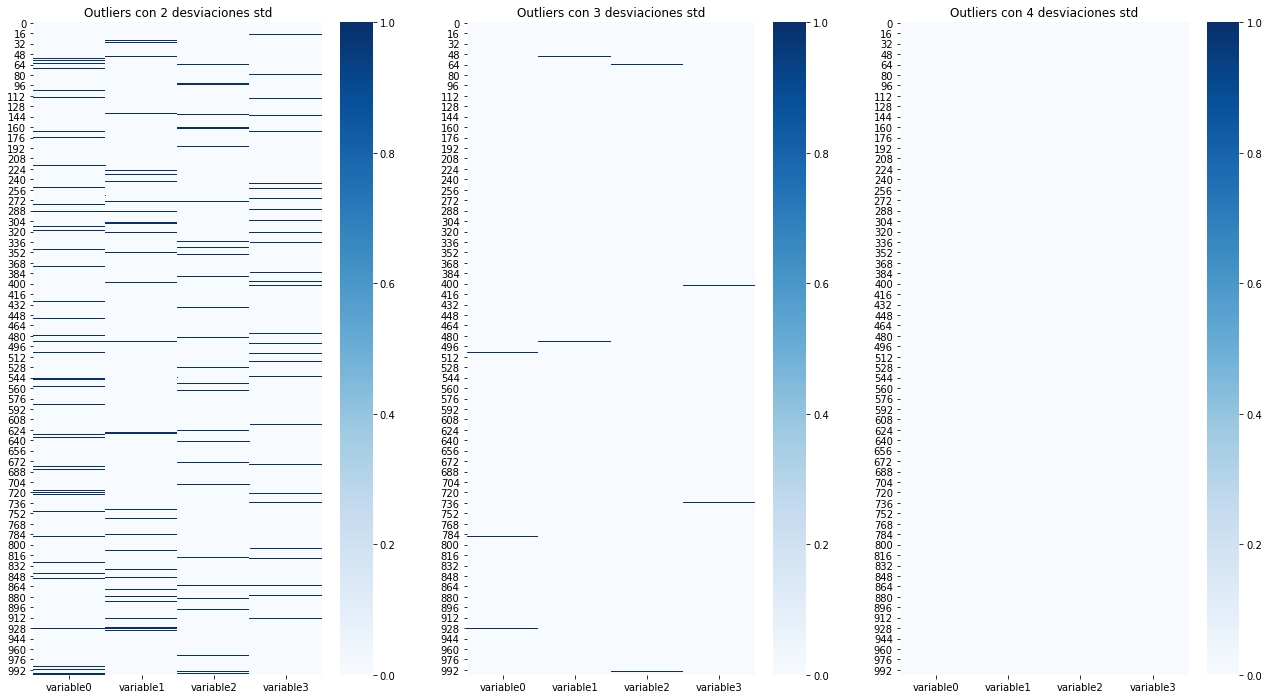

In [ ]:
# Lo ploteamos, mientras más azul en el mapa de calor, más Outliers tiene el dataset
f, ((ax1, ax2, ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(22, 12));
ax1.set_title('Outliers con 2 desviaciones std');
ax2.set_title('Outliers con 3 desviaciones std');
ax3.set_title('Outliers con 4 desviaciones std');
# Creamos un heatmap con seaborn. 
sns.heatmap(std2, cmap='Blues', ax=ax1, vmin=0, vmax=1);
sns.heatmap(std3, cmap='Blues', ax=ax2,vmin=0, vmax=1);
sns.heatmap(std4, cmap='Blues', ax=ax3,vmin=0, vmax=1);

**Puedes hacer lo mismo con el rango intercuartil?**

También es conveniente plotear los rangos o *cutoff* de la serie.

In [ ]:
def plot_cutoff(dataframe, col, nstd=2.0, color='red'):
    """
    Plotea los límites inferiores y superiores de una distribución normal
    :param dataframe: Dataframe de pandas
    :param col: Columna del dataframe
    :param nstd: Numero de desviaciones std. 
    :param color: Color 
    :return: Un plot 
    """
    lower, upper = out_std(dataframe[col], nstd=nstd, return_thresholds=True)
    plt.axvspan(min(dataframe[col][dataframe[col] < lower], 
                    default=dataframe[col].min()), lower, alpha=0.2, color=color);
    plt.axvspan(upper, max(dataframe[col][dataframe[col] > upper],
                           default=dataframe[col].max()), alpha=0.2, color=color);

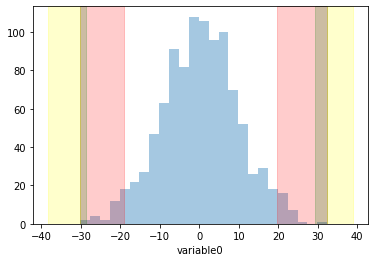

In [ ]:
col = 'variable0'
sns.distplot(df_sin[col], kde=False)
plot_cutoff(df_sin, col, nstd=2.0, color='red');
plot_cutoff(df_sin, col, nstd=3.0, color='green');
plot_cutoff(df_sin, col, nstd=4.0, color='yellow');

# Métodos de Machine Learning

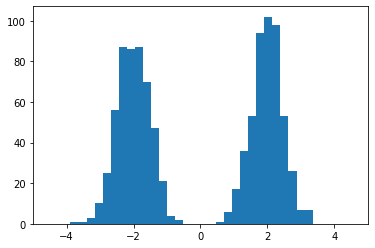

In [ ]:
# Creamos un nuevo dataset sintético
# Creamos una serie con Numpy de 500 puntos
x = np.concatenate((np.random.normal(loc=-2, scale=.5,size=500), 
                    np.random.normal(loc=2, scale=.5, size=500)))
plt.hist(x, bins = 30) # Histograma de la serie
plt.xlim([-5, 5])
plt.show()

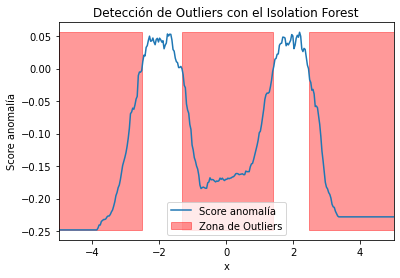

In [ ]:
from sklearn.ensemble import IsolationForest
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(x.reshape(-1, 1))
# Creamos una segunda serie para plotearla y ver si tene outliers 
# con los límites de la anterior funcion. (-5,5)
xx = np.linspace(-5, 5, 300).reshape(-1,1) # límite inferior, límite superior, num puntos
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.plot(xx, anomaly_score, label='Score anomalía')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='Zona de Outliers')
plt.legend()
plt.ylabel('Score anomalía')
plt.xlabel('x')
plt.xlim([-5, 5])
plt.title("Detección de Outliers con el Isolation Forest")
plt.show()

# Volvemos al ejemplo anterior

In [ ]:
# Seleccionamos una de las columnas y la formateamos
x = df_sin.variable0.values
x = x.reshape(-1, 1) # Reshape para ponerlo en el formato indicado
# Entrenamos el modelo
isolation_forest = IsolationForest(n_estimators=200)
isolation_forest.fit(x)
outliers = isolation_forest.predict(x) 
anomaly_score = isolation_forest.decision_function(x)

In [ ]:
temp_df = pd.DataFrame(
    {
        'variable0':df_sin.variable0,
        'outlier':outliers, 
        'anomaly_socre':anomaly_score
    }
)

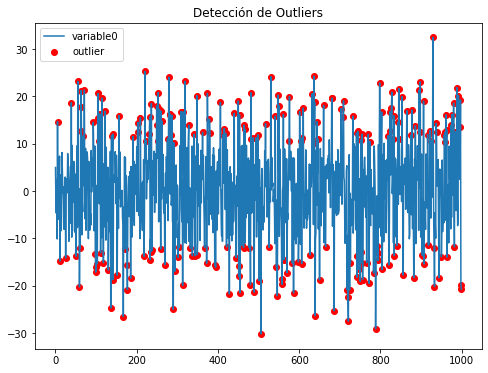

In [ ]:
# Lo vemos graficamente
fig, ax = plt.subplots(figsize=(8,6))

outliers_df = temp_df[temp_df.outlier==-1] # Filtramos los outliers
ax.scatter(outliers_df.index,
           outliers_df.variable0,c='r',label='outlier')
ax.plot(temp_df.variable0, label='variable0')
ax.set_title('Detección de Outliers')
plt.legend()
plt.show();

# Multivariable Outlier Detection

Vamos a utilizar un algoritmo no supervisado, usualmente asociado a Clustering llamado DBScan. Muy útil al encontrar relaciones no lineales, basado en densidades, lo que lo hace muy útil para encontrar Outliers

Más info: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

Ventajas: 

- No necesitas definir el número de K. 
- Robusto a Oultiers, ya que en su definición los "etiqueta" como tal si no tienen una cantidad considerable de vecinos (baja densidad)
- Excelente algoritmo en distribuciones arbitrarias


In [38]:
df_sin_2 = df_sin.copy()

In [39]:
df_sin_2 = df_sin_2.append(
    # agregamos datos sintéticos con el mismo método pero en otra escala
    pd.DataFrame(
        np.random.normal(
            scale=100.0, size=(10, n_feats)),  # diferente escala
            columns=[f'variable{i}' for i in range(n_feats)]
    )   
)

In [44]:
df_sin_2.describe()

,variable0,variable1,variable2,variable3
count,1010.000000,1010.000000,1010.000000,1010.000000
mean,-0.058650,0.350196,0.407533,0.451394
std,13.649696,14.163303,16.876784,13.283153
min,-201.021665,-135.286589,-150.722582,-133.022626
25%,-6.132492,-6.774639,-6.903452,-6.802176
50%,0.568315,0.202097,-0.075088,0.211577
75%,6.692147,7.083433,6.503879,7.009570
max,58.388302,166.293145,258.357366,164.142863


In [42]:
X = StandardScaler().fit_transform(df_sin_2)
db = DBSCAN(eps=3.0, min_samples=10).fit(X)
labels = db.labels_


In [41]:
pd.Series(labels).value_counts()


 0    1000
-1      10
dtype: int64

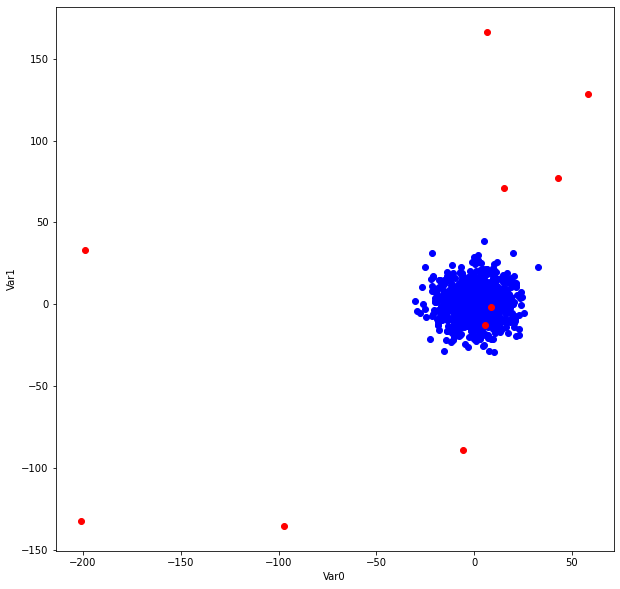

In [49]:
plt.figure(figsize=(10,10))

unique_labels = set(labels)
colors = ['blue', 'red']

for color,label in zip(colors, unique_labels):
    sample_mask = [True if l == label else False for l in labels]
    plt.plot(
        df_sin_2["variable0"][sample_mask], 
        df_sin_2["variable1"][sample_mask], 
        'o',
        color=color
    )
plt.xlabel('Var0')
plt.ylabel('Var1')
plt.show()

Aún vemos algunos outliers en dentro de la masa de pelotas azules, pero si lo vemos en más dimensiones, será más claro

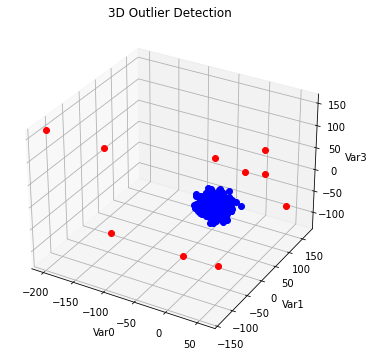

In [57]:
# Lo ploteamos en 3D 

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')

for color, label in zip(colors, unique_labels):
    sample_mask = [True if l == label else False for l in labels]
    plt.plot(
        df_sin_2["variable0"][sample_mask], 
        df_sin_2["variable1"][sample_mask],
        df_sin_2["variable3"][sample_mask],
        'o',
        color=color
    )
    plt.title('3D Outlier Detection')
ax.set_xlabel('Var0')
ax.set_ylabel('Var1')
ax.set_zlabel('Var3')
plt.show()